In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import numpy as np
import os
from tensorflow.keras.models import load_model # type: ignore
import tensorflow as tf
import pandas as pd
import json

# Local imports
from src.lstm_2.model_generation.helper_methods import generate_data, order_features_config
from src.data_processing.lstm_data_preprocessing import FeaturesConfig


2025-04-27 17:03:23.648723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745769803.747373   60070 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745769803.777482   60070 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745769803.896240   60070 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745769803.896385   60070 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745769803.896387   60070 computation_placer.cc:177] computation placer alr

In [3]:
# Custom loss function
def weighted_mse_large_moves(y_true, y_pred):
    diff = y_true - y_pred
    weight = tf.math.square(y_true)
    return tf.reduce_mean(weight * tf.square(diff))

# Empty dictionary to hold all models
models = {}

# Create placeholder variable names (or models if already trained)
batch_sizes = [16, 32, 64, 128, 256]

for feature_set in range(1, 4):  # 1 to 3
    for batch_size in batch_sizes:
        model_folder = f"../model_generation/trained_models/lstm_{feature_set}_{batch_size}"
        model_name = f"model_{feature_set}_{batch_size}"
        with open(os.path.join(model_folder, "config.json"), 'r') as f:
            configs = json.load(f)
        features_config = configs["features_config"]
        time_bucket_folder = configs["time_bucket_folder"]
        test_size = configs["test_size"]
        model = load_model(os.path.join(model_folder, "model.keras"),
            custom_objects={'weighted_mse_large_moves': weighted_mse_large_moves})
        models[model_name] = {"model": model, "feature_config": features_config, "time_bucket_folder": time_bucket_folder, "test_size": test_size}

I0000 00:00:1745769810.133863   60070 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:08:00.0, compute capability: 8.9


In [4]:
# 1. Get unique feature config / time bucket / test size combinations
unique_configs = set()

for model_info in models.values():
    config_key = (
        tuple(model_info["feature_config"].items()),
        model_info["time_bucket_folder"],
        model_info["test_size"]
    )
    unique_configs.add(config_key)

# 2. Generate datasets once per unique config
datasets = {}

for config in unique_configs:
    features_config, time_bucket_folder, test_size = config
    
    # Rebuild dict to then use in order_features_config method to get ordered list of boolean values for features
    ordered_features_config = order_features_config(dict(features_config))

    # Create FeaturesConfig object
    features_config = FeaturesConfig(*ordered_features_config)

    # Generate / load data
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = generate_data(
        features_config=features_config,
        time_bucket_folder=time_bucket_folder,
        test_size=test_size
    )

    datasets[config] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "X_scaler": X_scaler,
        "y_scaler": y_scaler
    }


In [5]:
model_results = {}

for model_name, model_info in models.items():
    # Rebuild the config_key using the tuple of (key, value) pairs for feature_config
    config_key = (
        tuple(model_info["feature_config"].items()),  # <-- Ensure feature_config is a tuple of (key, value)
        model_info["time_bucket_folder"],
        model_info["test_size"]
    )

    # Fetch the corresponding data from datasets using the correct config_key
    data = datasets[config_key]

    X_test = data["X_test"]
    y_test = data["y_test"]
    model = model_info["model"]

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform to get real values
    y_pred_actual = data["y_scaler"].inverse_transform(y_pred)
    y_test_actual = data["y_scaler"].inverse_transform(y_test)

    # Save the predictions and actual values in model_results
    model_results[model_name] = {"pred": y_pred_actual, "real": y_test_actual}


I0000 00:00:1745769835.798075   60173 cuda_dnn.cc:529] Loaded cuDNN version 90300


523/523 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 29s 55ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 31s 59ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 31s 59ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 31s 59ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step


In [9]:
import pickle

# Save model_results to a file
with open("all_model_results.pkl", "wb") as f:
    pickle.dump(model_results, f)

print("model_results saved successfully!")


model_results saved successfully!


In [6]:
from metrics_methods import get_model_comparison

model_comparison = get_model_comparison(model_results, threshold=1.5)

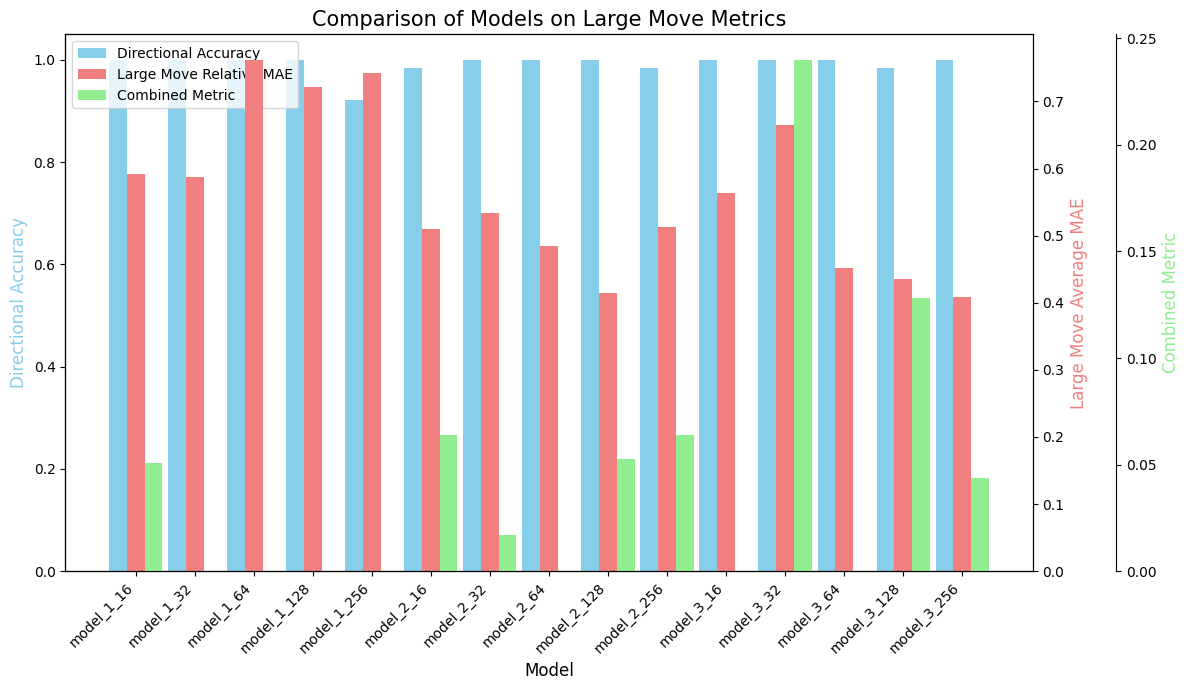

In [7]:
from visualisation_methods import plot_multiple_model_results_old


plot_multiple_model_results_old(model_comparison)

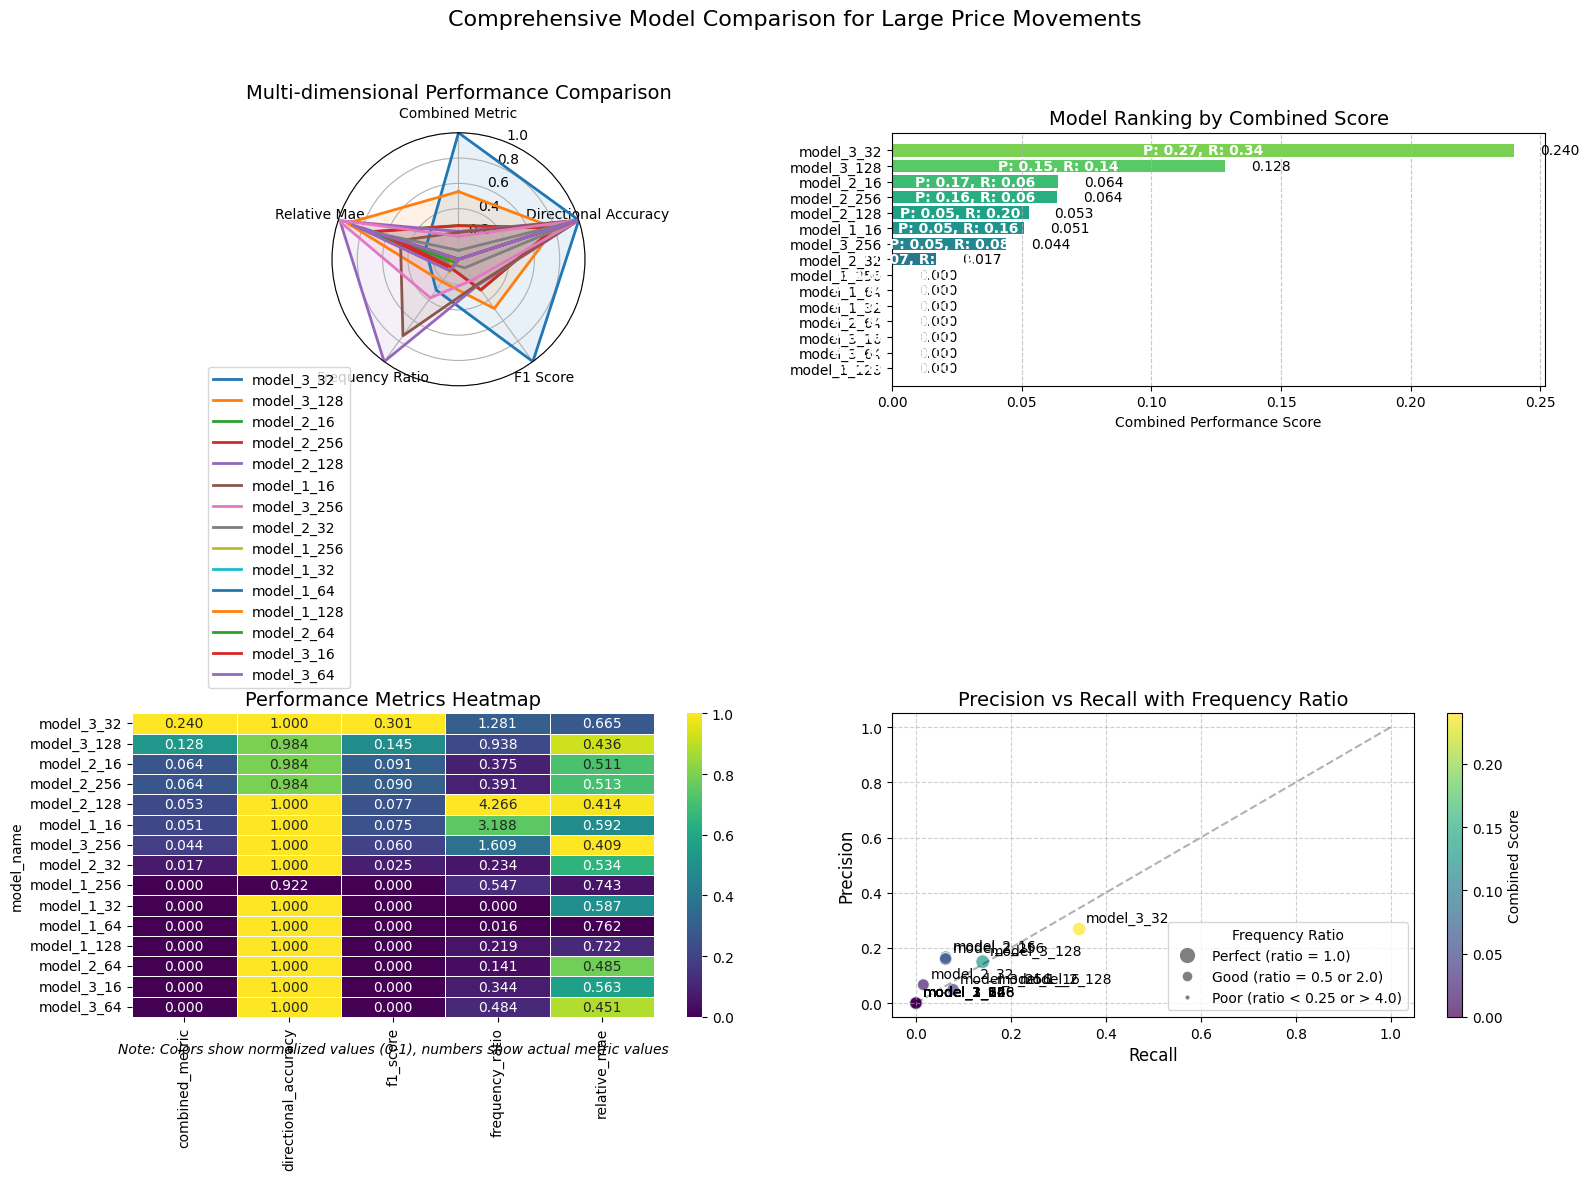

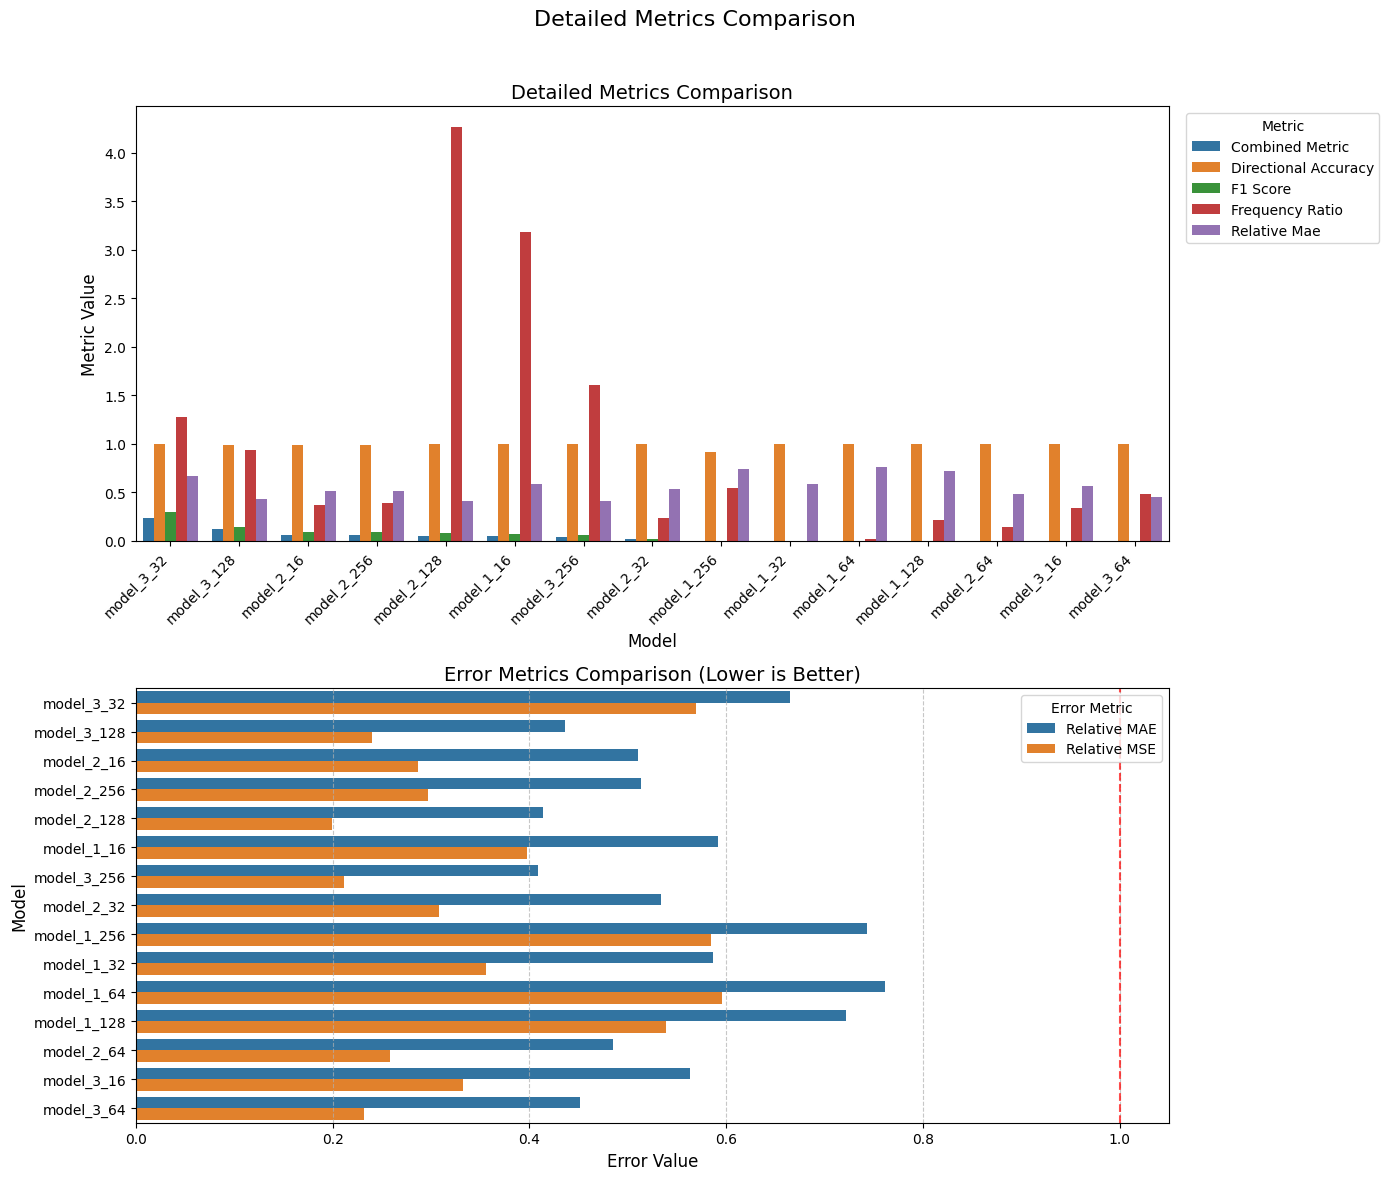

In [8]:
from visualisation_methods import plot_multiple_model_results

plot_multiple_model_results(model_comparison)